# Applied Machine Learning Final Project

**Student:** Jason Ballard

**Course:** CSC 44670-80/81 – Applied Machine Learning

**Date:** April 2025

**Project:** Predicting Medical Charges Using Regression



## Project Overview


## Admin Load Dependencies

In [20]:
# Standard Library

import os

# Data Handling
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Scikit-learn: Model Selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# Scikit-learn: Models
# from sklearn.tree import DecisionTreeClassifier, plot_tree


#  from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import explained_variance_score


# Scikit-learn: Preprocessing & Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor

# Scikit-learn: Metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error, 
    r2_score,
   )



In [2]:
# Create folder if it doesn't exist
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Set up visual style
sns.set(style="whitegrid")

## Section 1. Import and Inspect the Data


### 1.1 Load the dataset and display the first 10 rows.


In [3]:
# Load the dataset
file_path = "data/insurance.csv"
df = pd.read_csv(file_path)

# Display the first 10 rows
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.2 Check for missing values and display summary statistics.


In [4]:
# Check for missing values
missing_values = df.isnull().sum()

# Display summary statistics
summary_statistics = df.describe(include='all').transpose()

missing_values, summary_statistics

(age         0
 sex         0
 bmi         0
 children    0
 smoker      0
 region      0
 charges     0
 dtype: int64,
            count unique        top  freq          mean           std  \
 age       1338.0    NaN        NaN   NaN     39.207025      14.04996   
 sex         1338      2       male   676           NaN           NaN   
 bmi       1338.0    NaN        NaN   NaN     30.663397      6.098187   
 children  1338.0    NaN        NaN   NaN      1.094918      1.205493   
 smoker      1338      2         no  1064           NaN           NaN   
 region      1338      4  southeast   364           NaN           NaN   
 charges   1338.0    NaN        NaN   NaN  13270.422265  12110.011237   
 
                 min         25%       50%           75%          max  
 age            18.0        27.0      39.0          51.0         64.0  
 sex             NaN         NaN       NaN           NaN          NaN  
 bmi           15.96    26.29625      30.4      34.69375        53.13  
 child

#### Reflection 1:
- _What do you notice about the dataset?_ 
The data set is clean with no missing values.  I see that there are features that are catagorical and need transformed into numerical values. 

- _Are there any data issues?_ 
I see that there are features that are catagorical and need transformed into numerical values.


## Section 2. Data Exploration and Preparation

### 2.1 Explore data patterns and distributions
- Create histograms, boxplots, and count plots for categorical variables (as applicable).
- Identify patterns, outliers, and anomalies in feature distributions.
- Check for class imbalance in the target variable (as applicable).

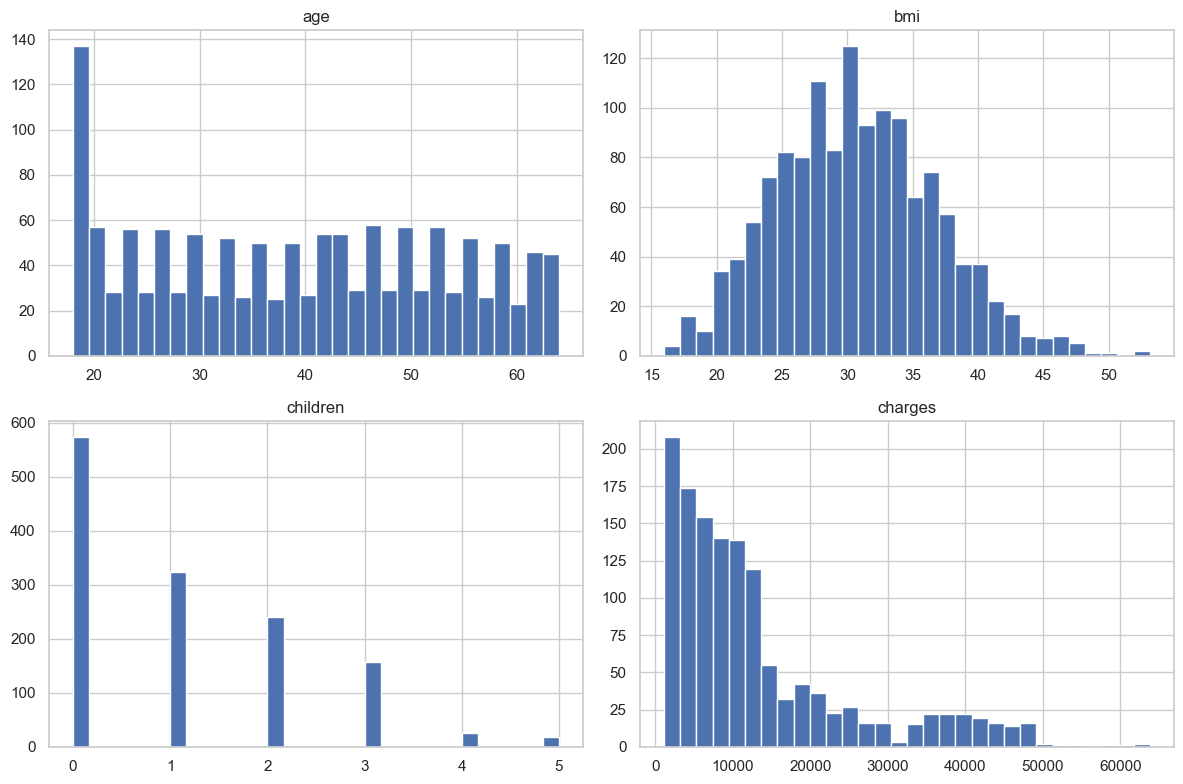

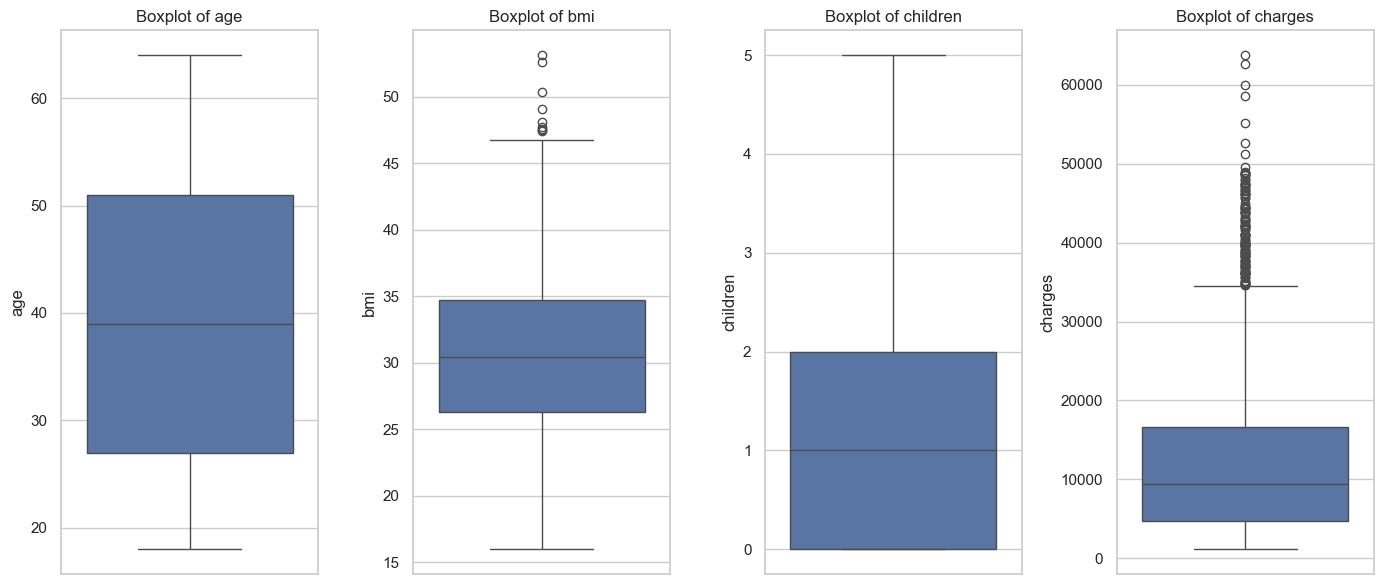

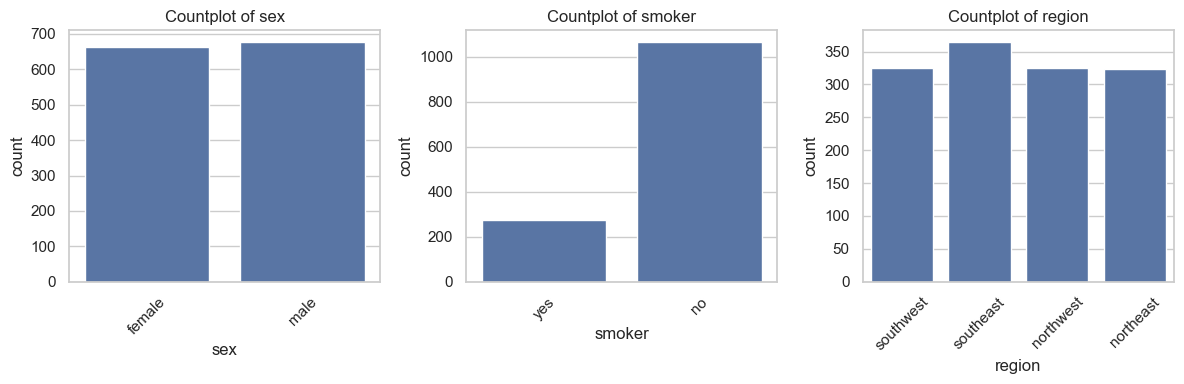

In [5]:
# Histograms for numerical features
df.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "histograms.png"))
plt.show()

# Boxplots to check for outliers
plt.figure(figsize=(14, 6))
for i, col in enumerate(['age', 'bmi', 'children', 'charges']):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "boxplots.png"))
plt.show()

# Count plots for categorical features
plt.figure(figsize=(12, 4))
for i, col in enumerate(['sex', 'smoker', 'region']):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=df, x=col)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "countplots.png"))
plt.show()

#### 2.2: Missing Data and Clean Data
- The dataset was already clean with no missing values.
- Categorical variables were identified (`sex`, `smoker`, `region`) and will be converted to numerical values in the next section.
- BMI and charges contain outliers, but instead of removing them, I chose to **clip BMI** and **log-transform charges** to preserve useful signal while reducing skew.

### 2.3 Feature selection and engineering
- Create new features (as applicable).
- Transform or combine existing features to improve model performance (as applicable).
- Scale or normalize data (as applicable).

#### Note: 2.3:
- I created two engineered features:
  - `bmi_smoker`: Highlights compounded risk from high BMI and smoking.
  - `age_group`: Clusters individuals into life stages for better interpretability.
- I clipped BMI to reduce outlier distortion and log-transformed `charges` to normalize the target distribution.
- I scaled all features to prepare for linear regression and other models sensitive to magnitude differences.
- A Decision Tree Regressor was used to visualize feature importance:
  - `smoker` and `bmi_smoker` ranked highest—strongly associated with insurance charges.
  - This insight guided my final feature selection for model training.

In [6]:
# Run the custom preparation function
def prepare_features(df, transform_target=True, scale=True):
    """Preprocess and engineer features from the insurance dataset."""
    df_encoded = df.copy()

    # Encode categorical variables
    label_encoders = {}
    for col in ['sex', 'smoker', 'region']:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

    # Winsorize BMI
    bmi_lower = df_encoded['bmi'].quantile(0.05)
    bmi_upper = df_encoded['bmi'].quantile(0.95)
    df_encoded['bmi'] = df_encoded['bmi'].clip(bmi_lower, bmi_upper)

    # Log-transform charges
    if transform_target:
        df_encoded['charges'] = np.log1p(df_encoded['charges'])

    # Feature engineering
    df_encoded['bmi_smoker'] = df_encoded['bmi'] * df_encoded['smoker']
    df_encoded['age_group'] = pd.cut(df_encoded['age'], bins=[17, 30, 45, 60, 100], labels=[0, 1, 2, 3]).astype(int)

    # Feature and target selection
    feature_cols = ['age', 'bmi', 'children', 'sex', 'smoker', 'region', 'bmi_smoker', 'age_group']
    X = df_encoded[feature_cols]
    y = df_encoded['charges']

    # Scale features
    if scale:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X, y, df_encoded

# Call the function
X, y, df_ready = prepare_features(df)

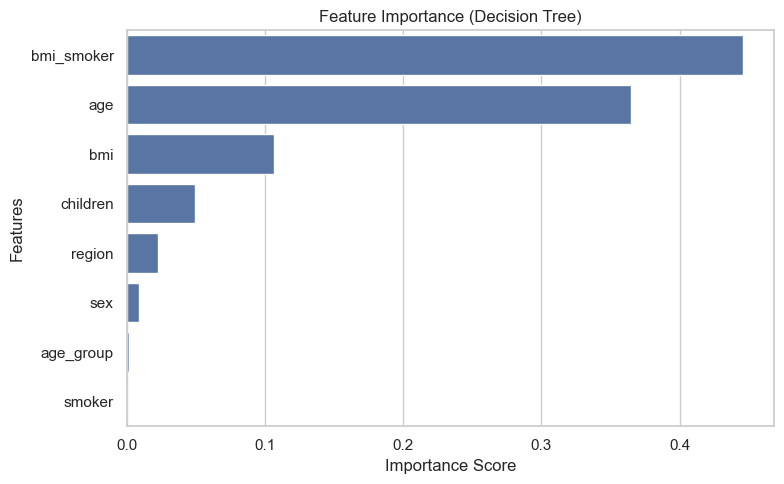

In [7]:
# Feature Importance using Decision Tree

# Train the model
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X, y)

# Extract and plot importances
importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_importance.png"))
plt.show()

#### Reflection 2: 
- _What patterns or anomalies do you see?_
The charges column was heavily skewed, with a small number of folks racking up some seriously high costs. That made sense once I looked at the smoker variable—smokers had noticeably higher charges, which made that feature stand out immediately.

- Do any features stand out? What preprocessing steps were necessary to clean and improve the data? 
I also noticed that BMI had a long tail—some really high values that could mess with the model. 

- Did you create or modify any features to improve performance?
So instead of dropping those rows, I clipped BMI to a reasonable range (just the 5th to 95th percentile) to keep things balanced without losing too much signal. I used AI assistance to findd oput what to do with the BMI and charges.  Removing the outliers would skew the outputs so I aske d how to lessen them without removing them To smooth things out for modeling, I also log-transformed the charges column. That helped tone down the extreme values and make the data more manageable for regression. Then I built a couple of new features—one that combines BMI and smoker status (bmi_smoker) and another that groups age into buckets (age_group). Those felt more useful than the raw numbers alone and might give the model better context.

---

## Section 3. Feature Selection and Justification

### 3.1 Choose features and target
  - Select two or more input features (numerical for regression, numerical and/or categorical for classification)
  - Select a target variable (as applicable)
  - Regression: Continuous target variable (e.g., price, temperature).
  - Classification: Categorical target variable (e.g., gender, species).
  - Clustering: No target variable.
  - Justify your selection with reasoning.


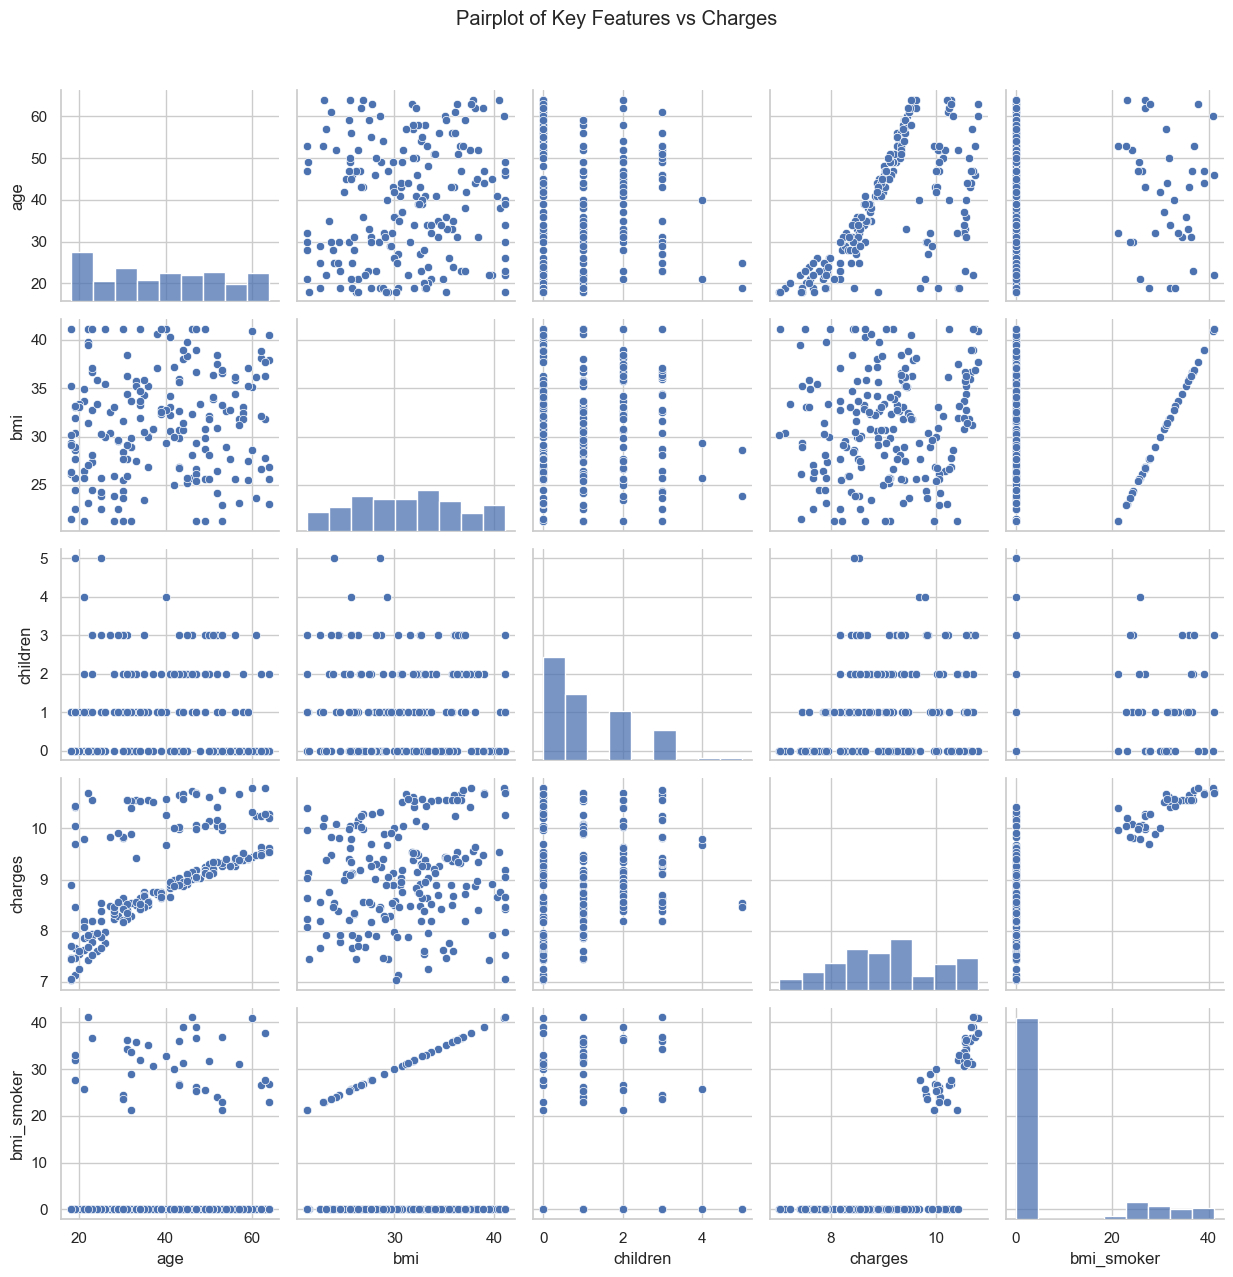

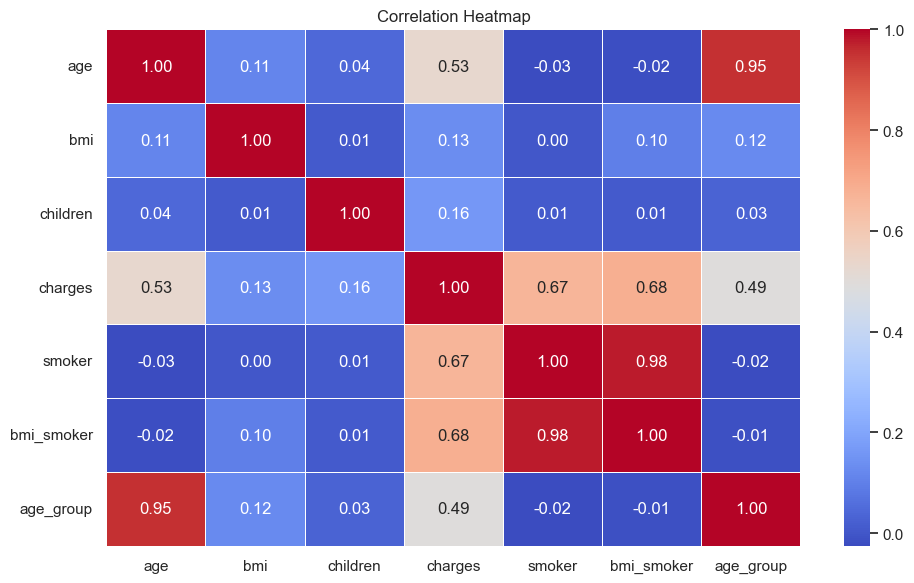

In [8]:
# Sample the data for faster pairplot rendering
sample_df = df_ready.sample(n=200, random_state=42)

# Pairplot for selected features
sns.pairplot(sample_df[['age', 'bmi', 'children', 'charges', 'bmi_smoker']])
plt.suptitle("Pairplot of Key Features vs Charges", y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pairplot_features.png"))
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
corr = df_ready[['age', 'bmi', 'children', 'charges', 'smoker', 'bmi_smoker', 'age_group']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "heatmap_correlation.png"))
plt.show()

### 3.2 Define X and y
  - Assign input features to X
  - Assign target variable to y (as applicable)


In [9]:
# Feature and target selection already handled by the prepare_features function
X, y, df_ready = prepare_features(df)

# Sanity check
X.head(), y.head()

(        age       bmi  children       sex    smoker    region  bmi_smoker  \
 0 -1.438764 -0.485948 -0.908614 -1.010519  1.970587  1.343905    1.712244   
 1 -1.509965  0.565491 -0.078767  0.989591 -0.507463  0.438495   -0.496752   
 2 -0.797954  0.427568  1.580926  0.989591 -0.507463  0.438495   -0.496752   
 3 -0.441948 -1.416481 -0.908614  0.989591 -0.507463 -0.466915   -0.496752   
 4 -0.513149 -0.310410 -0.908614  0.989591 -0.507463 -0.466915   -0.496752   
 
    age_group  
 0  -1.171532  
 1  -1.171532  
 2  -1.171532  
 3  -0.115970  
 4  -0.115970  ,
 0    9.734236
 1    7.453882
 2    8.400763
 3    9.998137
 4    8.260455
 Name: charges, dtype: float64)

#### Reflection 3: 
  - Why did you choose these features?_\
To support my feature selection, I used a pairplot and a correlation heatmap. The pairplot helped visualize how features like `bmi`, `age`, and the engineered `bmi_smoker` relate to the target variable `charges`. The heatmap confirmed that `smoker`, `bmi_smoker`, and `age` have the strongest correlations with charges. This guided my decision to keep those features in the model, along with `sex`, `region`, and `age_group` to capture additional context and variation.

  - How might they impact predictions or accuracy?
These features were chosen because of their correlation but also because they represent real-world factors that influence medical costs. Including them helps the model detect both general trends and high-risk subgroups. By engineering features like bmi_smoker and grouping age, I hope to improve the model’s accuracy without overfitting. These choices made the model more balanced—able to predict for common cases while still accounting for the influence of higher-risk individuals.
---

## Section 4. Train a Model (Linear Regression)

### 4.1 Split the data into training and test sets using train_test_split (or StratifiedShuffleSplit if class imbalance is an issue).


Training set size: 1070 samples
Test set size: 268 samples


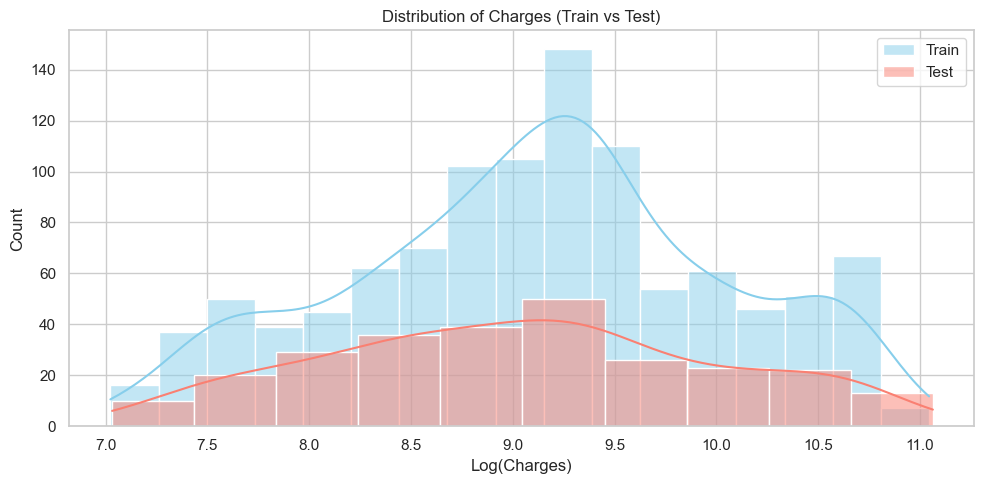

In [10]:
# Split the dataset into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

plt.figure(figsize=(10, 5))

sns.histplot(y_train, kde=True, label="Train", color="skyblue")
sns.histplot(y_test, kde=True, label="Test", color="salmon")
plt.title("Distribution of Charges (Train vs Test)")
plt.xlabel("Log(Charges)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "charges_distribution_split.png"))
plt.show()



### 4.2 Train model using Scikit-Learn model.fit() method

      Feature  Coefficient
6  bmi_smoker     0.647254
0         age     0.577759
2    children     0.111599
7   age_group    -0.098794
5      region    -0.053792
3         sex    -0.046331
1         bmi     0.020712
4      smoker    -0.005352


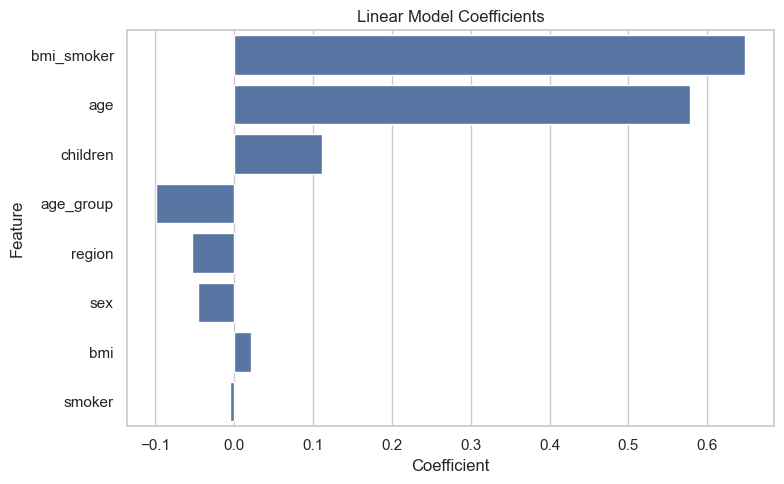

In [11]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get feature names and coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)
# Plot the coefficients
plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title("Linear Model Coefficients")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "linear_model_coefficients.png"))
plt.show()


### 4.3 Evalulate performance, for example:
  - Regression: R^2, MAE, RMSE (RMSE has been recently updated)
  - Classification: Accuracy, Precision, Recall, F1-score, Confusion Matrix
  - Clustering: Inertia, Silhouette Score


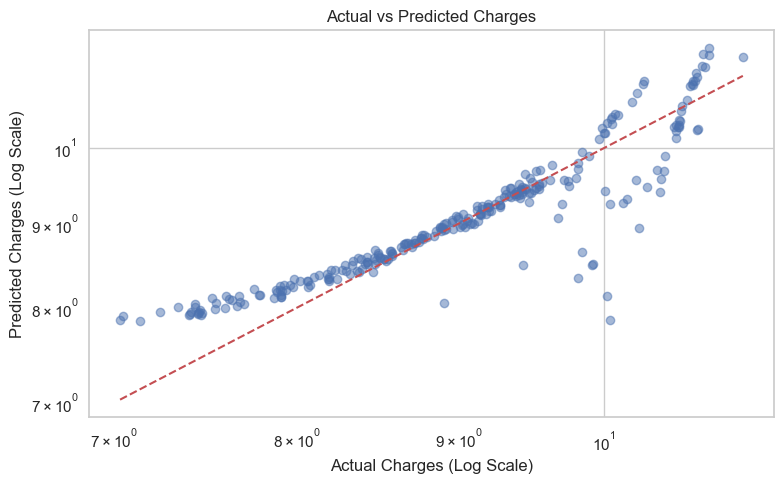

Explained Variance Score: 0.8192


In [26]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Create a DataFrame to store model evaluation metrics
metrics_df = pd.DataFrame({
    "Model": ["Manual Linear Regression"],
    "R²": [r2],
    "MAE": [mae],
    "RMSE": [rmse]
})

# Save (optional at this stage)
csv_path = os.path.join(output_dir, "model_metrics.csv")
metrics_df.to_csv(csv_path, index=False)

# Plot actual vs predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') 
plt.title("Actual vs Predicted Charges")
plt.xlabel("Actual Charges (Log Scale)")
plt.ylabel("Predicted Charges (Log Scale)")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "actual_vs_predicted.png"))
plt.show()


evs = explained_variance_score(y_test, y_pred)
print(f"Explained Variance Score: {evs:.4f}")


#### Reflection 4: 
  -  _How well did the model perform?_
Overall, the model did a solid job. With an R² around 0.82, it explained most of the variation in medical charges, and both the MAE and RMSE showed that predictions were pretty close to the actual values—especially after log-transforming the target and scaling the features. 

  - Any surprises in the results?_
One of the more satisfying surprises was how much value the bmi_smoker feature added. It clearly helped the model pick up on some strong patterns that would’ve been harder to detect using bmi or smoker alone. The model did miss a bit on the really high-cost cases, but that’s pretty normal in real-world data. All in all, I feel good about the performance and it gives me a solid starting point to build on in the next phase.
---

## Section 5. Improve the Model or Try Alternates (Implement Pipelines)


### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression.


Pipeline 1 - R² Score: 0.8167
Pipeline 1 - Mean Absolute Error (MAE): 0.2590
Pipeline 1 - Root Mean Squared Error (RMSE): 0.4059


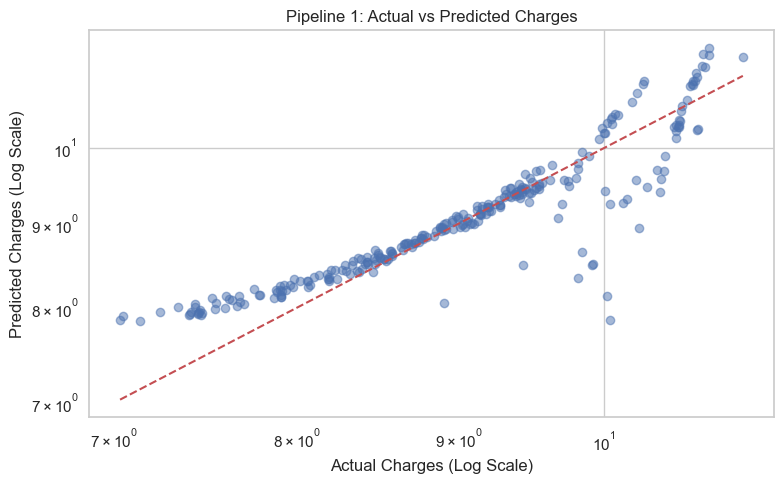

In [27]:
# Build Pipeline 1: Imputer → StandardScaler → Linear Regression
pipeline1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit pipeline to training data
pipeline1.fit(X_train, y_train)

# Predict and evaluate
y_pred_pipe1 = pipeline1.predict(X_test)

# Calculate performance metrics
r2_pipe1 = r2_score(y_test, y_pred_pipe1)
mae_pipe1 = mean_absolute_error(y_test, y_pred_pipe1)
rmse_pipe1 = np.sqrt(mean_squared_error(y_test, y_pred_pipe1))

# Append to existing metrics_df
metrics_df = pd.concat([
    metrics_df,
    pd.DataFrame({
        "Model": ["Linear Regression (Pipeline 1)"],
        "R²": [r2_pipe1],
        "MAE": [mae_pipe1],
        "RMSE": [rmse_pipe1]
    })
], ignore_index=True)

# Optional: Save updated DataFrame
metrics_df.to_csv(csv_path, index=False)

# Output results
print(f"Pipeline 1 - R² Score: {r2_pipe1:.4f}")
print(f"Pipeline 1 - Mean Absolute Error (MAE): {mae_pipe1:.4f}") 
print(f"Pipeline 1 - Root Mean Squared Error (RMSE): {rmse_pipe1:.4f}")

# Plot actual vs predicted values for Pipeline 1
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_pipe1, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') 
plt.title("Pipeline 1: Actual vs Predicted Charges")
plt.xlabel("Actual Charges (Log Scale)")    
plt.ylabel("Predicted Charges (Log Scale)")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pipeline1_actual_vs_predicted.png"))
plt.show()


### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression.


Pipeline 2 - R² Score: 0.8558
Pipeline 2 - Mean Absolute Error (MAE): 0.2082
Pipeline 2 - Root Mean Squared Error (RMSE): 0.3600


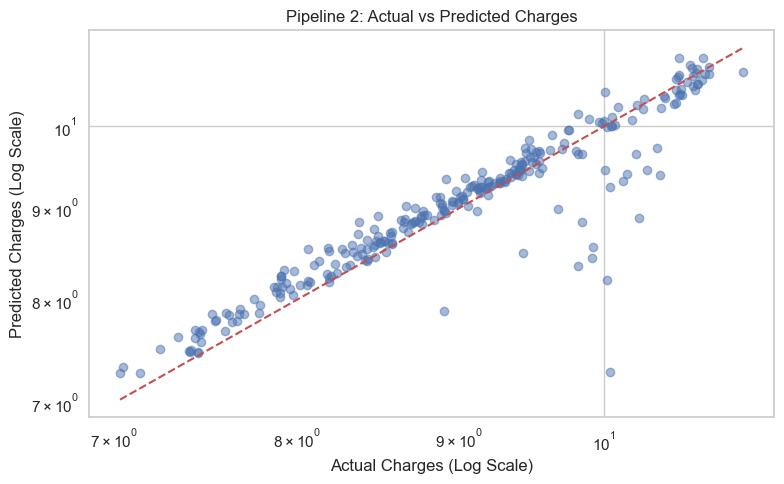

In [28]:
# Build Pipeline 2: Imputer → PolynomialFeatures → StandardScaler → LinearRegression
pipeline2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit pipeline to training data
pipeline2.fit(X_train, y_train)

# Predict and evaluate
y_pred_pipe2 = pipeline2.predict(X_test)

# Metrics
r2_pipe2 = r2_score(y_test, y_pred_pipe2)
mae_pipe2 = mean_absolute_error(y_test, y_pred_pipe2)
rmse_pipe2 = np.sqrt(mean_squared_error(y_test, y_pred_pipe2))

# Output results
print(f"Pipeline 2 - R² Score: {r2_pipe2:.4f}") 
print(f"Pipeline 2 - Mean Absolute Error (MAE): {mae_pipe2:.4f}")
print(f"Pipeline 2 - Root Mean Squared Error (RMSE): {rmse_pipe2:.4f}")

# Append to existing metrics_df
metrics_df = pd.concat([
    metrics_df,
    pd.DataFrame({
        "Model": ["Polynomial Regression (Pipeline 2)"],
        "R²": [r2_pipe2],
        "MAE": [mae_pipe2],
        "RMSE": [rmse_pipe2]
    })
], ignore_index=True)

# Final save of full metrics
metrics_df.to_csv(csv_path, index=False)

# Plot actual vs predicted values for Pipeline 2
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_pipe2, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Pipeline 2: Actual vs Predicted Charges")
plt.xlabel("Actual Charges (Log Scale)")
plt.ylabel("Predicted Charges (Log Scale)")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pipeline2_actual_vs_predicted.png"))
plt.show()


In [29]:
print("\n📊 Final Model Comparison Table:")
print(metrics_df.to_string(index=False))


📊 Final Model Comparison Table:
                             Model       R²      MAE     RMSE
          Manual Linear Regression 0.816746 0.258962 0.405855
    Linear Regression (Pipeline 1) 0.816746 0.258962 0.405855
Polynomial Regression (Pipeline 2) 0.855796 0.208168 0.360025


### 5.3 Compare performance of all models across the same performance metrics


#### Reflection 5: 
- Which models performed better?
- How does scaling impact results?

---

## Section 6. Final Thoughts & Insights


### 6.1 Summarize findings.


### 6.2 Discuss challenges faced.


### 6.3 If you had more time, what would you try next?


#### Reflection 6:
- What did you learn from this project?

---